
# <center> IMA205 Challenge 2022-Classify dermoscopic images among 8 different diagnostic classes



First Name : Chaima <br>
Family Name : ELMESSAI

In [ ]:
from google.colab import drive
import glob
import os 
import numpy as np
import math
import cv2
from scipy import ndimage
import seaborn as sns
from scipy.stats import gaussian_kde
import skimage.morphology as morpho 
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage import binary_dilation
from skimage.morphology import dilation
from skimage.morphology import disk 
from skimage import img_as_ubyte, feature
from  sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# I- Loading and visualizing Data :

In [ ]:
def plot_image (path, ID):
  " This function allows to plot an image and its segmentation "
  # Reading the original image and its segmentation using the path 
  image = imread(path +'/' + ID + '.jpg') 
  segmentation = imread(path +'/' + ID + '_seg.png') 
  # Plotting the original image and its segmentation mask
  fig = plt.figure(figsize=(10, 10)) # size of the figure
  grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
  grid[0].imshow(image)
  grid[0].axis('off')
  grid[0].set_title('Original image')
  grid[1].imshow(segmentation)
  grid[1].axis('off')
  grid[1].set_title("Segmentation mask")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Working_directory = '/content/drive/MyDrive/ChallengeIMA/Data/'

* **Visualizing the metadataTrain:** 



In [ ]:
csv_file = pd.read_csv(Working_directory + 'metadataTrain.csv') 
csv_file.head(10)

,ID,CLASS,SEX,AGE,POSITION
0,ISIC_0028766,2,male,30.0,NaN
1,ISIC_0071222,8,male,85.0,lower extremity
2,ISIC_0069434,3,male,85.0,head/neck
3,ISIC_0062098,1,male,55.0,head/neck
4,ISIC_0057224,8,female,45.0,lower extremity
5,ISIC_0056307,6,female,45.0,anterior torso
6,ISIC_0025306,2,female,45.0,posterior torso
7,ISIC_0029785,2,male,70.0,anterior torso
8,ISIC_0067798,1,male,55.0,anterior torso
9,ISIC_0054278,2,male,45.0,anterior torso


- **Visualizing train samples from the different classes :**

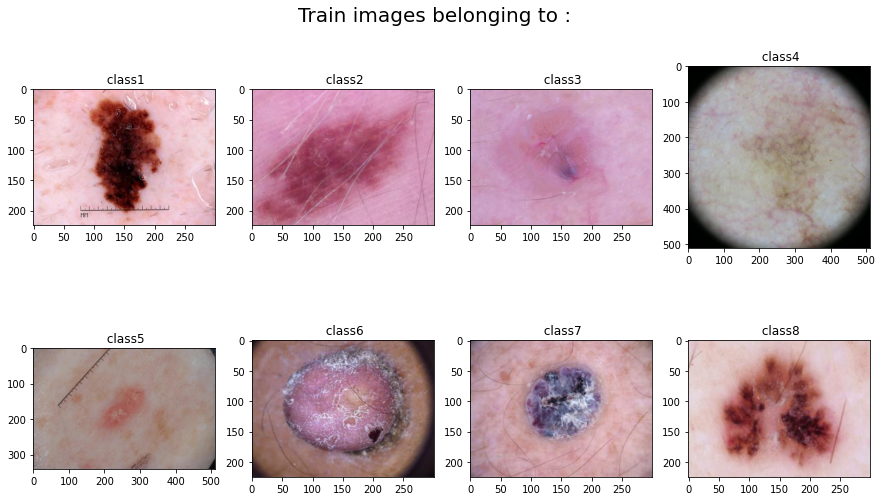

In [ ]:
trainData_path = Working_directory + 'Train'
fig, axs = plt.subplots(2, 4,figsize=(15,8))
fig.suptitle(f'Train images belonging to : ',fontsize=20)
# I chose this list of ID because every ID corresponds to an image from a different class
ID_list = ['ISIC_0032447','ISIC_0032434','ISIC_0032482','ISIC_0057042','ISIC_0013165','ISIC_0032410','ISIC_0032557','ISIC_0027303']
k=0
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9 , top=0.9  , wspace=0.2, hspace=0.2)
for i in range(2):
  for j in range(4):
    image = imread (trainData_path + '/' + ID_list[k] + '.jpg')
    axs[i][j].imshow(image)
    axs[i][j].set_title(' class' + str (k+1))
    axs[i][j].grid(False)
    k+=1
  
plt.show()


> **Interpretation :** <br>
- As we can see images differs basing on  the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion 
So we need to extract specific features features to classify images.


- The segmentation is provided for some train and test images so we need to segment the other images but before proceeding to segmentation we need to apply pre_traitement to the images in order to  get a good segmentation

* **getting the ids of the train and the test images:**

In [ ]:
def images_Ids(path, file_type):
  list_files = [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(path) for f in files if f.endswith(file_type)]
  images_Ids = []
  for i in list_files :
    id = i.split('/')[-1].split('.jpg')[0]
    images_Ids.append(id)
  
  return images_Ids
  

In [ ]:
train_images_path =  Working_directory + 'Train'
train_images_Ids = images_Ids(train_images_path,'.jpg')

In [ ]:
test_images_path =  Working_directory + 'Test/Test'
test_images_Ids = images_Ids(test_images_path,'.jpg')


# II - Pre-processing 


- **Filtering :**

I'm going to apply a simple averaging in order to remove the noise.



In [ ]:
def noise_filtering(im):
  d = 5
  kernel = np.ones((d,d), np.float32) / (d**2)
  filtred_im = cv2.filter2D(im, -1, kernel)

  return filtred_im



- **Hair removal**

> In order to detect and then remove the hair  For the detection and removal of hair, I'm going to apply a series of  of morphological operations to the image in order to generate a mask that contains the hairs : <br>

1- Converting the original image to grayscale.<br>
2- Applying Closing to the grayscale image, using a linear or cross-shaped kernel.<br>
3- Calculating the difference between the resulting image and the original.<br>
for the step 2 and 3 of the DullRazor algorithm,I'm going to use the advanced morphological operation blackhat from the OpenCV library was used. 
4- Applying binary thresholding to obtain a mask with the hairs in the image.<br>
5- Replace the pixels in common between the mask and the original image, with pixels from the latter.<br>



In [ ]:
def hair_removal(im):
  # Converting the image to gray-scale
  gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY )

  # getting the struncturing element which is a linear kernel
  kernel = cv2.getStructuringElement(1,(9,9)) 

  # applying a morphological close to the grayscale image and computing the difference between 
  # the image after closing and the original image using the morphological operation blackhat
  res_im = cv2.morphologyEx(gray_im, cv2.MORPH_BLACKHAT, kernel)

  # getting the hair mask by applying thresholding
  _,mask = cv2.threshold(res_im,10,255,cv2.THRESH_BINARY)
  
  # replacing the values of pixels located in the mask by interpolation 
  final_image = cv2.inpaint(im,mask,6,cv2.INPAINT_TELEA) 

  return final_image


* **Border removal :**<br>
I'm going to use the region mergin algorithm in order to generate four masks that correspond to the four black corners. To do this I need to determine the threshold that will be used in the region mergin algorithm, so I'm going to estimate the valley region then determine the thresholds corresponding to these regions using otsu algorithm. By considering the least value of the founded thresholds while applying the region mergin algorithm we get the four masks that allows as to remove the black border.


In [ ]:
def cum_historgram(im,hist):
    histo_cum=hist/(im.shape[0]*im.shape[1])
    for k in range(1,hist.shape[0]):
        histo_cum[k]+=histo_cum[k-1]
    return histo_cum

def mean_level(h,n,m,level):
    histo=h.copy()
    histo=histo/(m*n)
    mean=0
    for i in range(level):
        mean+=i*histo[i]
    return mean

def otsu_segmentation(im,hist):
    cum_h = cum_historgram(im,hist)

    mean = mean_level(hist,im.shape[0],im.shape[1],hist.shape[0])
    
    between_class_var,tau_out=0,0
    for tau in range(1,hist.shape[0]):
        weight_tau = cum_h[tau-1]
        mean_tau=mean_level(hist,im.shape[0],im.shape[1],tau)
            
        if (weight_tau>0) and (weight_tau<1):
            var_tau = ((mean*weight_tau-mean_tau)**2)/(weight_tau*(1-weight_tau)) 
            if var_tau>between_class_var:
                between_class_var=var_tau
                tau_out = tau
    return tau_out, between_class_var

def threshold_regions (im):
    hist, grisLevel =np.histogram(im, 256)
    # computing the normalized binned histogram
    M=64
    L=256
    normalized_hist = np.zeros((M, 1), dtype=np.float32)
    N = L // M
    counters = [range(x, x+N) for x in range(0, L, N)]
    for i, C in enumerate(counters):
        normalized_hist[i] = 0
        for j in C:
            normalized_hist[i] += hist[j]
    normalized_hist = (normalized_hist /normalized_hist.max()) * 100
    # valley estimation
    hist_size = normalized_hist.shape[0]
    proba = np.zeros((hist_size, 1), dtype=int)
    costs = np.zeros((hist_size, 1), dtype=float)
    for i in range(1, hist_size-1):
        if normalized_hist[i] > normalized_hist[i-1] or normalized_hist[i] > normalized_hist[i+1]:
            proba[i] = 0
        elif normalized_hist[i] < normalized_hist[i-1] and normalized_hist[i] == normalized_hist[i+1]:
            proba[i] = 1
            costs[i] = normalized_hist[i-1] - normalized_hist[i]
        elif normalized_hist[i] == normalized_hist[i-1] and normalized_hist[i] < normalized_hist[i+1]:
            proba[i] = 3
            costs[i] = normalized_hist[i+1] - normalized_hist[i]
        elif normalized_hist[i] < normalized_hist[i-1] and normalized_hist[i] < normalized_hist[i+1]:
            proba[i] = 4
            costs[i] = (normalized_hist[i-1] + normalized_hist[i+1]) - 2*normalized_hist[i]
        elif normalized_hist[i] == normalized_hist[i-1] and normalized_hist[i] == normalized_hist[i+1]:
            proba[i] = proba[i-1]
            costs[i] = proba[i-1]
    for i in range(1, hist_size-1):
        if proba[i] != 0:
            proba[i] = (proba[i-1] + proba[i] + proba[i+1]) // 4
    valleys = [i for i, x in enumerate(proba) if x > 0]
    #  compute the thresholds of the valley regions
    thresholds = []
    for valley in valleys:
        start_pos = (valley * N) - N
        end_pos = (valley + 2) * N
        h = hist[start_pos:end_pos]
        sub_threshold, var = otsu_segmentation(im,h)
        thresholds.append((start_pos + sub_threshold, var))
    thresholds.sort(key=lambda x: x[1], reverse=True)
    thresholds, values = [list(t) for t in zip(*thresholds)]

    return thresholds

In [ ]:
def initialize_segmentation(seed_pt,img_shape):
    seg_init = np.zeros(img_shape).astype(float)
    seg_init[ seed_pt[0], seed_pt[1]] = 1
    dist = distance_transform_edt(np.abs(1-seg_init))
    # initialise the seeded region with a certain radius
    size_radius = 5
    seg_init = dist < size_radius
    return seg_init
def segmentation_region_growing(img,seed_pt,tau):

    # define the neighbourhood (for instance 4-connected pixels)
    nbhood = np.asarray( [ [0,1,0],[1,1,1],[0,1,0]] )

    seg_init = initialize_segmentation(seed_pt,img.shape)
    seg_n_plus_1 = seg_init
    seg_n = np.zeros(seg_n_plus_1.shape)

    # loop while the region can still keep growing
    while( np.abs(seg_n_plus_1 != seg_n).sum() != 0):
        seg_n = seg_n_plus_1
        seg_n_plus_1 = binary_dilation(seg_n, structure=nbhood).astype(seg_n.dtype)
        seg_n_plus_1 = np.logical_and( seg_n_plus_1 , np.abs( img )< tau)
        # do not lose previous points of the segmentation
        seg_n_plus_1 = np.logical_or( seg_n_plus_1 , seg_n)

    return seg_n

def black_border_removal(im):
  thresholds = threshold_regions(im)
  thresholds.sort()
  # Creation of four masks : in each mask the white region is one of the four corners
  mask1 = segmentation_region_growing(im,(0,0),thresholds[0])
  mask2 = segmentation_region_growing(im,(im.shape[0]-1,0),thresholds[0])
  mask3 = segmentation_region_growing(im,(0,im.shape[1]-1),thresholds[0])
  mask4 = segmentation_region_growing(im,(im.shape[0]-1,im.shape[1]-1),thresholds[0])

  # The final mask is a mask where the white regions corresponds to the four black corners 
  mask = mask1 + mask2 + mask3 + mask4

  # Image without Black border 
  res = im.copy()
  res[mask==1] = 255

  return res

- I'm going to test the function on some samples of the train dataset

In [ ]:
trainData_path = Working_directory + 'Train'

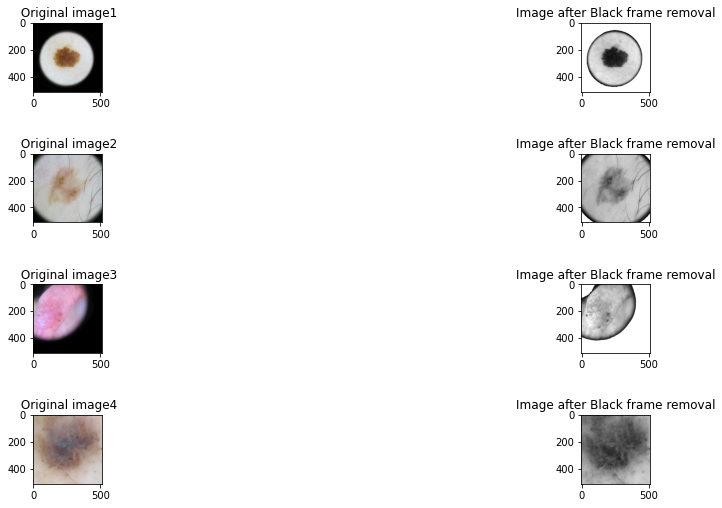

In [ ]:
fig, axs = plt.subplots(4, 2,figsize=(15,8))
# I chose this list of ID because every ID corresponds to an image having different forms of black frame and I chose one image that doesn't have a black frame 
ID_list = ['ISIC_0069952','ISIC_0069982','ISIC_0069975','ISIC_0073238']
k=0
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9 , top=0.9  , wspace=0.9, hspace=0.9)

for i in range(4):
  image = imread (trainData_path + '/' + ID_list[k] + '.jpg')
  removed_border_image = black_border_removal(image[:,:,2])
  axs[i][0].imshow(image)
  axs[i][0].set_title(' Original image' + str (k+1))
  axs[i][1].imshow(removed_border_image, cmap = 'gray')
  axs[i][1].set_title('Image after Black frame removal' )
  axs[i][0].grid(False)
  axs[i][1].grid(False)
  k+=1

plt.show()

- As we can see **for different forms of the black border**, we obtain a satisfying result.

- **Intensity adjasement or color adjasement :**




In [ ]:
def intensity_adjustement(im):
  " This function allows to stretch th histogram of the input function by mapping the minimum and maximum "
  " intensity values to 0 and 255 with a certain percentage of saturation that I chose equal to 50%"

  satur_percentage = 50 
  im_array = im.flatten()
  im_array.sort()
  im_min , im_max=  im_array[satur_percentage], im_array[ im_array.shape[0] - satur_percentage]

  adjusted_im = (im - im_min)*(255/(im_max - im_min + 0.001))
  adjusted_im = adjusted_im.astype(int)
  adjusted_im[im>im_max] = 255
  adjusted_im[im<im_min] = 0

  return adjusted_im



# II - Segmentation

- For the segmentation, I'm going to use the function **otsu_segmentation** that I have used to remove the border in order to segment the test and train images.

In [ ]:
def otsu(im):
  # compute the histogram 
  hist = np.zeros(256) 
  for i  in range(im.shape[0]):
    for j in range(im.shape[1]):
      index = im[i,j]
      hist[index]+=1

  tau, var = otsu_segmentation(im,hist)
  seg_im = np.zeros((im.shape[0],im.shape[1]))
  seg_im[im<tau]=255

  return seg_im

# III - Post-processing


- **connected component analysis :**

In [ ]:
def connectedComponents_analysis(mask):
  
  # transforming the input mask to a 2 dimentional array that is used as an input to the cv2.connectedComponentsWithStats 
  # function that allow to determine the connected component 
  arr = np.array(mask, dtype=np.uint8)
  num_cc, cc, stat, centroid = cv2.connectedComponentsWithStats(arr)

  # getting and sorting the areas of the connected components
  areas_cc = stat[:,4] 
  sorted_areas = np.sort(areas_cc)

  # In case where the number of connected component is superior to 2, we keep only the two biggest areas by filling  
  # with black the connected components having areas that are inferior to the second biggest area 
  returned_mask = mask.copy() 
  if (num_cc ==2):
    return returned_mask
  elif (num_cc > 2):
    for i in range(num_cc):
      if(areas_cc[i]<sorted_areas[-2]):
        returned_mask[cc == i] = 0
  
  return returned_mask

- **Morphological filling : filling the holes**

In [ ]:
def Morphological_fillingHoles(im,r):

  image = im.copy()
  L = np.arange(-r, r + 1)
  x,y= np.meshgrid(L, L)
  mask= x**2+y**2 <= r**2
  mask = mask.astype(np.float32)
  dilated = dilation(image, mask)
  return dilated

- I'm going to represent the hole process of segmentation in the following function: the image will be segmented in the blue channel.



In [ ]:
def segmentation(im):
  # Filtering
  filtred_im = noise_filtering(im)
  # Hair removal
  im_hairRemoval =hair_removal(filtred_im)
  # Getting the image in the blue channel
  im_blue = im_hairRemoval [:,:,2]
  # Black border removal
  im_blackBorderRemoval = black_border_removal(im_blue)
  # Intensity adjustement
  adjusted_im = intensity_adjustement(im_blackBorderRemoval)
  # otsu segmentation
  seg_im = otsu(adjusted_im)
  # Connected components analysis
  seg_im_CCA = connectedComponents_analysis(seg_im)
  # Filling the holes
  filled_im = Morphological_fillingHoles(seg_im_CCA,5)

  list_images = [filtred_im,im_hairRemoval,im_blackBorderRemoval,adjusted_im,seg_im,seg_im_CCA,filled_im ]
  return list_images  

- I'm going to segment all the images of the train set and the test set that are not segmented : <br>
I have saved the segmented train images in the Train folder and the segmented test images in the test folder. 


In [ ]:
# Segmentation of the train images
for id in train_images_Ids:
  seg_im_path = train_images_path+'/'+id+'_seg.png'
  seg_im_path1 = train_images_path+'/'+id+'_seg_otsu.png'
  if not(os.path.exists(seg_im_path)) and not (os.path.exists(seg_im_path1)):
    im = np.array(imread(train_images_path+'/'+id+'.jpg'))
    seg_im = segmentation(im)[6]
    cv2.imwrite(os.path.join(train_images_path, id+'_seg_otsu.png'), seg_im)
  



In [ ]:
# Segmentation of the test images
for id in test_images_Ids:
  seg_im_path = test_images_path+'/'+id+'_seg.png'
  seg_im_path1 = test_images_path+'/'+id+'_seg_otsu.png'
  if not(os.path.exists(seg_im_path)) and not (os.path.exists(seg_im_path1)):
    im = np.array(imread(test_images_path+'/'+id+'.jpg'))
    seg_im = segmentation(im)[6]
    cv2.imwrite(os.path.join(test_images_path, id+'_seg_otsu.png'), seg_im)

# III- Feature Extraction :

>For the feature extraction, I'm going to use the ABCD rule :

- **Asymmetry** : I'm going to use the descriptors mentionned in the article that is entitled "Performance of a dermoscopy-based computer vision system for the
diagnosis of pigmented skin lesions compared with visual evaluation
by experienced dermatologists"  : Asymmetry of shape(2 features) and asymmetry of color intensity(2 features) and other assymetry features like the solidity, the extent and the ratio between the perimeter of the contour and its area So we will have in total 7 assymetry features <br>
- **Border irregularity**: I'm going to use the average and the variance of the magnitude of the gradient of the border pixels in each of the R, G and B channels as features.So we will have 6 border features in total.

- **Color variegation:** : I will follow the article which is entitled " A computational approach for detecting pigmented skin lesions in macroscopic images" and use the mean and the standard deviation of histograms of the image in 6 color channels which are R, G, B, H and V and I will follow the article "Performance of a dermoscopy-based computer vision system for the
diagnosis of pigmented skin lesions compared with visual evaluation
by experienced dermatologists" and compute the the mean value of the
three L∗ a∗ b∗ components in the inside and outside of the lesion area, and take
the difference between them as three color features ans I will also compute the probability density estimate of the samples of each L∗ a∗ b∗ channel in the innermost and outermost parts ofthe regions as three other features.<br>
- **Dimension of the lesion** : I will use the equivalent diameter  whiwh reprsents the diameter of a circle with the same area as the lesion region.


> I will also **add four texture features** : homogeneity,correlation,contrast and energy.

In [ ]:
def contours(seg_im):
  contours, hierarchy = cv2.findContours(seg_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  cnt = contours[0][:,0]
  return cnt

##### Asymmetry ######
# 1- Asymmetry of shape
def DeltaS1_score(gray_im, binary_mask):

  # Determining the center coordinates using the moments of the binary mask
  moment_dict = cv2.moments(binary_mask)
  xc = int(moment_dict['m10']/moment_dict['m00'])
  yc = int(moment_dict['m01']/moment_dict['m00'])

  # Computing the area of the contours used for normalization 
  cnt = contours(seg_im)
  area = cv2.contourArea(cnt)

  # Computing deltaS1_score 
  deltaS1_score = 0
  for i in range(0,min(yc,gray_im.shape[0]-yc)):
    for j in range(0,min(xc,gray_im.shape[1]-xc)):
            if ((binary_mask[yc-i,xc+j] != 0) or (binary_mask[yc+i,xc+j] != 0)):
              deltaS1_score += abs(gray_im[yc+i,xc+j]-gray_im[yc-i,xc+j])
                
    
  deltaS1_score = deltaS1_score/area

  return deltaS1_score

def Asymmetry_shape (im, seg_im):

  # Converting the input image to a gray_scale image 
  im1 = im.copy()
  gray_im = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

  # getting the binary mask from the segmented image
  thresh, binary_mask = cv2.threshold(seg_im.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)

  # Rotating the image in steps of 10 degrees (until achieving a rotation with 180 degrees angle) 
  # and computing at each step deltaS1_score.
  deltaScore_list = []  
  for i in range(18):
    rotated_gray_im = ndimage.rotate(gray_im, i*10)
    rotated_binary_mask = ndimage.rotate( binary_mask, i*10)
    delta_score = DeltaS1_score(rotated_gray_im, rotated_binary_mask)
    print('ok1')
    deltaScore_list.append(delta_score)
  
  # Remark : when the image is rotated with 90 degrees angle the deltaS1_score became equal  
  # to the deltaS2_score which measures the asymmetry between A1UA4 AND A2UA3.

  # Determination of the scores that minimize the average value
  deltaS1_score = deltaScore_list[0]
  deltaS2_score = deltaScore_list[9]
  min_average = deltaS1_score + deltaS2_score
  n = len(deltaScore_list)
  for i in range(1,n):
    if (deltaScore_list[i] + deltaScore_list[(i+9)%n]) < min_average :
      deltaS1_score = deltaScore_list[i]
      deltaS2_score = deltaScore_list[(i+9)%n]
      min_average = deltaS1_score + deltaS2_score
  
  return (deltaS1_score,deltaS2_score)

# 2- Asymmetry of color intensity
def DeltaC1_score(gray_im, binary_mask):

  # splitting the gray_im in two regions half top that represents the union of the two regions 
  # A1 and A2 and the half bottom that represents the union between the two regions A3 and A4.
  moment_dict = cv2.moments(binary_mask)
  yc = int(moment_dict['m01']/moment_dict['m00'])
  halfTop_im = gray_im [:yc,:]
  halfBottom_im = gray_im[yc:,:]

  # half top and half bottom regions corresponding to the lesion part of the gray-scale image
  halfTop_lesion = halfTop_im[(binary_mask[:yc,:]).astype(bool)]
  halfBottom_lesion = halfTop_im[(binary_mask[:yc,:]).astype(bool)]

  # computing the two estimated distributions of the 256 values of pixels that belongs to each 
  # of the two regions using Gaussian kernel density estimation.
  C_halfTop_lesion = (gaussian_kde(halfTop_lesion)).evaluate(np.arange(256))
  C_halfBottom_lesion = (gaussian_kde(halfBottom_lesion)).evaluate(np.arange(256))

  # Computing deltaC1_score
  deltaC1_score = np.sum(abs(C_halfTop_lesion - C_halfBottom_lesion))
  
  return deltaC1_score

def Asymmetry_colorIntensity(im,seg_im):

  # Converting the input image to a gray_scale image 
  im1 = im.copy()
  gray_im = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

  # getting the binary mask from the segmented image
  thresh, binary_mask = cv2.threshold(seg_im.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)

  # Rotating the image in steps of 10 degrees (until achieving a rotation with 180 degrees angle) 
  # and computing at each step deltac1_score.
  deltaScore_list = []  
  for i in range(18):
    rotated_gray_im = ndimage.rotate(gray_im, i*10)
    rotated_binary_mask = ndimage.rotate(binary_mask, i*10)
    delta_score = DeltaC1_score(rotated_gray_im, rotated_binary_mask)
    deltaScore_list.append(delta_score)
  
  # Determination of the scores that minimize the average value
  deltaC1_score = deltaScore_list[0]
  deltaC2_score = deltaScore_list[9]
  min_average = deltaC1_score + deltaC1_score
  n = len(deltaScore_list)
  for i in range(1,n):
    if (deltaScore_list[i] + deltaScore_list[(i+9)%n]) < min_average :
      deltaC1_score = deltaScore_list[i]
      deltaC2_score = deltaScore_list[(i+9)%n]
      min_average = deltaC1_score + deltaC2_score
  
  return (deltaC1_score,deltaC2_score)

# 3- Other features related to  assymetry(from the article Automated Prescreening of Pigmented Skin Lesions Using Standard Cameras)
def other_Asymetry_features(seg_im):
  cnt = contours(seg_im)
  # solidity
  contour_area = cv2.contourArea(cnt)
  convex_hull = cv2.convexHull(cnt)
  convex_hull_area = cv2.contourArea(convex_hull)
  solidity = contour_area/convex_hull_area

  # extent
  x,y,w,h = cv2.boundingRect(cnt)
  bounding_box_area = w*h
  extent = contour_area/bounding_box_area 

  # ratio between perimeter of the lesion and its area 
  perimeter = cv2.arcLength(cnt,True)
  ratio = perimeter/contour_area

  return (solidity,extent,ratio)

##### Border ######  
def extract_border_features(im,seg_im):
  # Determing the pixels coordinates that are in the contour 
  cnt = contours(seg_im)
  list_coordinates = cnt.tolist()
  
  # compute gradients along the x and y axis for the border pixels using the Sobel operator for 
  average_list = []
  variance_list = []
  for i in range(3):
    im_i = im[:,:,i]
    gx = cv2.Sobel(im[:,:,i], cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(im[:,:,i], cv2.CV_64F, 0, 1)
    # Computing the Average of the gradient magnitude of the pixels in the lesion in the ith channel
    magnitude = 0
    for j in range(len(list_coordinates)):
      l,c = list_coordinates[j][0], list_coordinates[j][1]
      if(l<im.shape[0])&(c<im.shape[1]):
        magnitude += np.sqrt((gx[l,c] ** 2) + (gy[l,c] ** 2))
    average_i = magnitude/len(list_coordinates)
    average_list.append(average_i)
    var = 0
    for k in range(len(list_coordinates)):
      l,c = list_coordinates[k][0], list_coordinates[k][1]
      if(l<im.shape[0])&(c<im.shape[1]):
        var += (np.sqrt((gx[l,c] ** 2) + (gy[l,c] ** 2)) - average_i)**2
    var_i = var/len(list_coordinates)
    variance_list.append(var_i) 

  
  return average_list, variance_list 
##### Color ######
# 10 color features corresponding to the mean and variation of the histogram of image in R,G,B,H and V channels
def extract_histograms_features(im, seg_im):
  
  list_ColorFeatures = []
  binary_mask = (seg_im.copy()/np.max(seg_im)).astype('float')
  binary_mask = binary_mask.astype(np.uint8)
  hist_R, hist_G , hist_B = cv2.calcHist([im], [0], binary_mask, [256], [0, 255]), cv2.calcHist([im], [1], binary_mask, [256], [0, 255]), cv2.calcHist([im], [2], binary_mask, [256], [0, 255])

  # Transforming the RGB image to the HSV color-space and compute histograms in the H and V channels
  img = im.copy()
  im_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
  hist_H, hist_V  = cv2.calcHist([im_HSV[:,:,0]], None, binary_mask, [256], [0, 255]), cv2.calcHist([im_HSV[:,:,2]], None, binary_mask, [256], [0, 255]) 
  
  list_histo = [hist_R,hist_G,hist_B,hist_H,hist_V]
  # Normalizing the histograms then computing the mean and the variance 
  list_ColorFeatures = []
  for hist in list_histo :
    cv2.normalize(hist,hist)
    list_ColorFeatures.append(np.mean(hist))
    list_ColorFeatures.append(np.var(hist))
  
  return list_ColorFeatures

# 6 color features corresponding to peripheral versus central
def compute_innerPartMask(binary_mask):

  # In order to get the inner part of the binary mask the all border points are moved the same number of pixels 
  # towards the center of mass until the outer/inner regions contain 30%/70% of the original pixels so binary_mask
  cnt = contours(binary_mask)
  total_area = cv2.contourArea(cnt)
  inner_area = total_area
  eroded_mask = binary_mask
  while (inner_area/total_area)> 0.7:
    eroded_mask = cv2.erode(eroded_mask, np.ones((5,5),np.uint8), iterations= 1)
    cnt_eroded = contours(eroded_mask)
    inner_area = cv2.contourArea(cnt_eroded)

  return eroded_mask

def innerOuter_LABFeatures(im,seg_im):

  # Getting the binary mask from the segmented image
  thresh, binary_mask = cv2.threshold(seg_im.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)

  # Getting the inner part mask and the outer part mask
  innerPart_mask = compute_innerPartMask(binary_mask)
  outerPart_mask = binary_mask - innerPart_mask

  # Converting the image to the CIE L∗ a∗ b∗ color-space
  LABim = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
  expanded_innerPart_mask = np.expand_dims(innerPart_mask, axis=2)
  expanded_outerPart_mask = np.expand_dims(outerPart_mask, axis=2)
  innerPart_LABim = LABim * expanded_innerPart_mask
  outerPart_LABim = LABim * expanded_outerPart_mask
  l_inner, a_inner, b_inner = innerPart_LABim[:,:,0],innerPart_LABim[:,:,1],innerPart_LABim[:,:,2]
  l_outer, a_outer, b_outer = outerPart_LABim[:,:,0],outerPart_LABim[:,:,1],outerPart_LABim[:,:,2]

  # Computing the three features as the differences of the mean values of the three components L,a and b 
  # in the inside and the outside parts 
  diffMean_innerOuter_L = (np.sum(l_inner)/np.sum(innerPart_mask)) - (np.sum(l_outer)/np.sum(outerPart_mask))
  diffMean_innerOuter_a = (np.sum(a_inner)/np.sum(innerPart_mask)) - (np.sum(a_outer)/np.sum(outerPart_mask))
  diffMean_innerOuter_b = (np.sum(b_inner)/np.sum(innerPart_mask)) - (np.sum(b_outer)/np.sum(outerPart_mask))

  return (diffMean_innerOuter_L,diffMean_innerOuter_a,diffMean_innerOuter_b)

def overlappingDensitiesArea_Features(im,seg_im):

  # Getting the binary mask from the segmented image
  thresh, binary_mask = cv2.threshold(seg_im.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)

  # Getting the inner part mask and the outer part mask
  innerPart_mask = compute_innerPartMask(binary_mask)
  outerPart_mask = binary_mask - innerPart_mask

  # inner and outer regions corresponding to the lesion part of the LAB image
  LABim = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
  innerPart_LABlesion = LABim[innerPart_mask.astype(bool),:]
  outerPart_LABlesion = LABim[outerPart_mask.astype(bool),:]

  l_inner, a_inner, b_inner = innerPart_LABlesion[:,0], innerPart_LABlesion[:,1], innerPart_LABlesion[:,2] 
  l_outer, a_outer, b_outer = outerPart_LABlesion[:,0], outerPart_LABlesion[:,1], outerPart_LABlesion[:,2]

  # compute the probability density estimate of the samples of each L∗ a∗ b∗ channel in the inner and the outer parts 
  # using Gaussian kernel density estimation.
  density_l_inner = (gaussian_kde(l_inner)).evaluate(np.arange(256))
  density_l_outer = (gaussian_kde(l_outer)).evaluate(np.arange(256))
  density_a_inner = (gaussian_kde(a_inner)).evaluate(np.arange(256))
  density_a_outer = (gaussian_kde(a_outer)).evaluate(np.arange(256))
  density_b_inner = (gaussian_kde(b_inner)).evaluate(np.arange(256))
  density_b_outer = (gaussian_kde(b_outer)).evaluate(np.arange(256))

  # Computing the features as the overlapping area of densities
  overlappingArea_l = (np.minimum(density_l_inner,density_l_outer)).sum() 
  overlappingArea_a = (np.minimum(density_a_inner,density_a_outer)).sum()
  overlappingArea_b = (np.minimum(density_b_inner,density_b_outer)).sum()

  return (overlappingArea_l,overlappingArea_a,overlappingArea_b)

   ##### Dimension ######
def equivalent_diameter(seg_im):
  cnt = contours(seg_im)
  area = cv2.contourArea(cnt)
  equi_diameter = np.sqrt(4*area/np.pi)
  return equi_diameter

  ##### Texture ######

def extract_Texture_features(im):
  gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY )
  GLCM_matrix = feature.greycomatrix(image=img_as_ubyte(gray_im), distances=[1],angles=[0, np.pi/4, np.pi/2, 3*np.pi /2],symmetric=True, normed=True)

  homogeneity = np.mean(feature.greycoprops(GLCM_matrix, prop='homogeneity'))
  correlation = np.mean(feature.greycoprops(GLCM_matrix, prop='correlation'))
  contrast = np.mean(feature.greycoprops(GLCM_matrix, prop='contrast'))
  energy = np.mean(feature.greycoprops(GLCM_matrix, prop='energy'))

  return (homogeneity,correlation,contrast,energy)




**When I applyed the feature extraction on the train set. For an exécution time of 12 hours I have obtained only results for 1308 samples of the train datasets that I saved in the following data frame.**


In [ ]:
train_f = pd.read_csv(Working_directory + 'extracted_features13.csv')

In [ ]:
train_f

,ID,deltaS1_score,deltaS2_score,solidity,extent,ratio,R_gradient_average,R_gradient_var,G_gradient_average,G_gradient_var,...,hist_B_var,hist_H_mean,hist_H_var,hist_V_mean,hist_V_var,equi_diameter,homogeneity,correlation,contrast,energy
0,ISIC_0072676,28.443076,44.987004,0.795358,0.541211,0.032867,0.000000,0.000000,0.000000,0.000000,...,0.003656,0.012120,0.003759,0.014590,0.003693,230.338646,0.753952,0.999568,1.138755,0.109103
1,ISIC_0071901,24.077006,31.027827,0.944180,0.862598,0.009847,0.000000,0.000000,0.000000,0.000000,...,0.002591,0.013327,0.003729,0.032534,0.002848,536.573659,0.489771,0.997241,5.307066,0.040775
2,ISIC_0071682,25.447301,30.232335,0.970180,0.761000,0.017842,0.000000,0.000000,0.000000,0.000000,...,0.002904,0.018501,0.003564,0.021297,0.003453,305.635615,0.784230,0.999626,4.532448,0.524261
3,ISIC_0071867,22.285649,50.356540,0.993195,0.890022,0.008023,0.000000,0.000000,0.000000,0.000000,...,0.003162,0.012239,0.003756,0.023335,0.003362,545.036339,0.588142,0.999066,2.363582,0.065266
4,ISIC_0072430,37.401920,39.004976,0.556517,0.442696,0.032751,0.000000,0.000000,0.000000,0.000000,...,0.002644,0.027233,0.003165,0.033279,0.002799,311.487838,0.515113,0.993497,62.636043,0.193631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,ISIC_0033159,15.250446,55.301366,0.972957,0.709905,0.040168,5.503088,158.068789,6.751499,230.126476,...,0.002610,0.010490,0.003796,0.037827,0.002475,122.485026,0.478873,0.996666,8.555826,0.065868
1304,ISIC_0031528,28.847334,40.785830,0.776959,0.578138,0.048447,3.104993,53.967885,3.070194,52.104860,...,0.003174,0.012212,0.003757,0.016549,0.003632,146.750038,0.409992,0.953817,6.603784,0.066396
1305,ISIC_0064321,49.437428,26.435033,0.958462,0.834160,0.009978,0.000000,0.000000,0.000000,0.000000,...,0.002070,0.017382,0.003604,0.041212,0.002208,506.624026,0.395483,0.996151,18.944332,0.029206
1306,ISIC_0059811,32.648798,30.817939,0.812286,0.631740,0.029962,0.000000,0.000000,0.000000,0.000000,...,0.003022,0.011646,0.003771,0.018083,0.003579,232.710251,0.533883,0.999137,4.318567,0.070986


**So I removed while applying the feature extraction to the train and test sets I have removed the assymetry shape, the assymetry color, the innerOuter_LABFeatures and the overlappingDensitiesArea_Features because they take so much time and I couldn't progress to the step of classification.**


In [ ]:
features_data_frame_train_final = pd.DataFrame(columns=['ID','solidity','extent','ratio','R_gradient_average','R_gradient_var',
'G_gradient_average','G_gradient_var','B_gradient_average','B_gradient_var','hist_R_mean','hist_R_var','hist_G_mean','hist_G_var','hist_B_mean','hist_B_var',
'hist_H_mean','hist_H_var','hist_V_mean','hist_V_var','equi_diameter','homogeneity','correlation','contrast','energy'])

for id in train_images_Ids:
  im = np.array(imread(train_images_path+'/'+id+'.jpg'))
  seg_im_path = train_images_path+'/'+id+'_seg.png'
  seg_im_path_otsu = train_images_path+'/'+id+'_seg_otsu.png'
  if os.path.exists(seg_im_path):
    seg_im = np.array(imread(seg_im_path))  
  else :
    seg_im = np.array(imread(seg_im_path_otsu))

  solidity = other_Asymetry_features(seg_im)[0]
  extent = other_Asymetry_features(seg_im)[1]
  ratio = other_Asymetry_features(seg_im)[2]
  R_gradient_average = extract_border_features(im,seg_im)[0][0]
  R_gradient_var = extract_border_features(im,seg_im)[1][0]
  G_gradient_average = extract_border_features(im,seg_im)[0][1]
  G_gradient_var = extract_border_features(im,seg_im)[1][1]
  B_gradient_average = extract_border_features(im,seg_im)[0][2]
  B_gradient_var = extract_border_features(im,seg_im)[1][2]
  hist_R_mean = extract_histograms_features(im, seg_im)[0]
  hist_R_var = extract_histograms_features(im, seg_im)[1]
  hist_G_mean = extract_histograms_features(im, seg_im)[2]
  hist_G_var = extract_histograms_features(im, seg_im)[3]
  hist_B_mean = extract_histograms_features(im, seg_im)[4]
  hist_B_var = extract_histograms_features(im, seg_im)[5]
  hist_H_mean = extract_histograms_features(im, seg_im)[6]
  hist_H_var = extract_histograms_features(im, seg_im)[7]
  hist_V_mean = extract_histograms_features(im, seg_im)[8]
  hist_V_var = extract_histograms_features(im, seg_im)[9]
  equi_diameter = equivalent_diameter(seg_im)
  homogeneity = extract_Texture_features(im)[0]
  correlation = extract_Texture_features(im)[1]
  contrast = extract_Texture_features(im)[2]
  energy = extract_Texture_features(im)[3]

  features_data_frame_train_final.loc[len(features_data_frame_train_final.index)] = [id,solidity,extent,ratio,R_gradient_average,R_gradient_var,G_gradient_average,G_gradient_var,B_gradient_average,B_gradient_var,
                                             hist_R_mean,hist_R_var,hist_G_mean,hist_G_var,hist_B_mean,hist_B_var,hist_H_mean,hist_H_var,hist_V_mean,hist_V_var,
                                             equi_diameter,homogeneity,correlation,contrast,energy] 

In [ ]:
features_data_frame_train_final 

,ID,solidity,extent,ratio,R_gradient_average,R_gradient_var,G_gradient_average,G_gradient_var,B_gradient_average,B_gradient_var,...,hist_B_var,hist_H_mean,hist_H_var,hist_V_mean,hist_V_var,equi_diameter,homogeneity,correlation,contrast,energy
0,ISIC_0059970,0.995514,0.778842,0.012317,35.848712,1036.135280,25.373867,443.310904,23.228137,351.356937,...,0.002331,0.010824,0.003789,0.031083,0.002940,343.058815,0.742518,0.999255,9.038131,0.561953
1,ISIC_0056275,0.996660,0.778410,0.009997,40.434345,1570.289508,24.072284,555.336181,26.250992,641.826912,...,0.002545,0.012986,0.003738,0.027994,0.003123,422.604738,0.706882,0.999667,4.395062,0.369685
2,ISIC_0065833,0.522580,0.392428,0.042186,33.064928,4088.028440,33.987616,4304.950331,36.431050,4519.859577,...,0.003028,0.018533,0.003563,0.026825,0.003187,345.643371,0.522119,0.915941,78.152439,0.080701
3,ISIC_0033796,0.937118,0.699420,0.029917,17.670207,178.358982,21.001745,300.183643,26.499450,543.376208,...,0.002822,0.013019,0.003737,0.040043,0.002303,163.857984,0.374718,0.997278,11.182199,0.041783
4,ISIC_0059047,0.996353,0.779833,0.008420,20.585308,83.700913,17.840261,58.497868,15.517820,56.427289,...,0.002488,0.011336,0.003778,0.027222,0.003165,502.709066,0.585824,0.999436,5.808331,0.169283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,ISIC_0060375,0.994068,0.777999,0.009263,45.065875,3558.686039,44.909329,3551.435909,47.571116,3894.994958,...,0.001365,0.029194,0.003054,0.051322,0.001272,461.809077,0.402658,0.987926,184.194853,0.145803
8590,ISIC_0025213,0.972782,0.727366,0.040644,25.318280,410.742981,23.442913,261.849752,24.260679,242.482922,...,0.002704,0.010669,0.003792,0.042711,0.002082,110.330443,0.474992,0.996323,6.861045,0.080718
8591,ISIC_0058694,0.961358,0.729560,0.016848,12.343390,298.405440,12.298953,290.810419,14.003734,328.218976,...,0.002394,0.012926,0.003739,0.035328,0.002658,278.522289,0.752979,0.998701,2.603208,0.117252
8592,ISIC_0057522,0.996230,0.797285,0.008269,22.874089,393.650643,17.127432,179.256969,15.668704,176.565753,...,0.002193,0.011370,0.003777,0.029665,0.003026,510.821249,0.574072,0.999471,5.335729,0.145918


**After removing the assymetry shape, the assymetry color, the innerOuter_LAB features and the overlappingDensitiesArea features, the feature extraction became faster but still slow so I stopped after the extraction of the features of  8594 train samples.**

In [ ]:
features_data_frame_train_final.to_csv('/content/drive/MyDrive/ChallengeIMA/Data/extracted_features_Train_final.csv')

In [ ]:
features_data_frame_test_final = pd.DataFrame(columns=['ID','solidity','extent','ratio','R_gradient_average','R_gradient_var',
'G_gradient_average','G_gradient_var','B_gradient_average','B_gradient_var','hist_R_mean','hist_R_var','hist_G_mean','hist_G_var','hist_B_mean','hist_B_var',
'hist_H_mean','hist_H_var','hist_V_mean','hist_V_var','equi_diameter','homogeneity','correlation','contrast','energy'])

for id in test_images_Ids:
  im = np.array(imread(test_images_path+'/'+id+'.jpg'))
  seg_im_path = test_images_path+'/'+id+'_seg.png'
  seg_im_path_otsu = test_images_path+'/'+id+'_seg_otsu.png'
  if os.path.exists(seg_im_path):
    seg_im = np.array(imread(seg_im_path))  
  else :
    seg_im = np.array(imread(seg_im_path_otsu))

  solidity = other_Asymetry_features(seg_im)[0]
  extent = other_Asymetry_features(seg_im)[1]
  ratio = other_Asymetry_features(seg_im)[2]
  R_gradient_average = extract_border_features(im,seg_im)[0][0]
  R_gradient_var = extract_border_features(im,seg_im)[1][0]
  G_gradient_average = extract_border_features(im,seg_im)[0][1]
  G_gradient_var = extract_border_features(im,seg_im)[1][1]
  B_gradient_average = extract_border_features(im,seg_im)[0][2]
  B_gradient_var = extract_border_features(im,seg_im)[1][2]
  hist_R_mean = extract_histograms_features(im, seg_im)[0]
  hist_R_var = extract_histograms_features(im, seg_im)[1]
  hist_G_mean = extract_histograms_features(im, seg_im)[2]
  hist_G_var = extract_histograms_features(im, seg_im)[3]
  hist_B_mean = extract_histograms_features(im, seg_im)[4]
  hist_B_var = extract_histograms_features(im, seg_im)[5]
  hist_H_mean = extract_histograms_features(im, seg_im)[6]
  hist_H_var = extract_histograms_features(im, seg_im)[7]
  hist_V_mean = extract_histograms_features(im, seg_im)[8]
  hist_V_var = extract_histograms_features(im, seg_im)[9]
  equi_diameter = equivalent_diameter(seg_im)
  homogeneity = extract_Texture_features(im)[0]
  correlation = extract_Texture_features(im)[1]
  contrast = extract_Texture_features(im)[2]
  energy = extract_Texture_features(im)[3]

  features_data_frame_test_final.loc[len(features_data_frame_test_final.index)] = [id,solidity,extent,ratio,R_gradient_average,R_gradient_var,G_gradient_average,G_gradient_var,B_gradient_average,B_gradient_var,
                                             hist_R_mean,hist_R_var,hist_G_mean,hist_G_var,hist_B_mean,hist_B_var,hist_H_mean,hist_H_var,hist_V_mean,hist_V_var,
                                             equi_diameter,homogeneity,correlation,contrast,energy] 

In [ ]:
features_data_frame_test_final

,ID,solidity,extent,ratio,R_gradient_average,R_gradient_var,G_gradient_average,G_gradient_var,B_gradient_average,B_gradient_var,...,hist_B_var,hist_H_mean,hist_H_var,hist_V_mean,hist_V_var,equi_diameter,homogeneity,correlation,contrast,energy
0,ISIC_0072313,0.909246,0.750596,0.032667,22.192218,511.307898,23.302782,537.931949,23.727994,589.562949,...,0.002768,0.010273,0.003801,0.036715,0.002558,149.772942,0.577851,0.998899,4.615743,0.094229
1,ISIC_0012549,0.926611,0.725320,0.049017,36.860898,2014.911446,37.554648,2012.221932,37.858086,1946.735920,...,0.003247,0.010272,0.003801,0.034254,0.002733,104.708480,0.275891,0.893290,134.075732,0.044347
2,ISIC_0026847,0.763305,0.496148,0.055778,38.608140,1478.254427,41.210254,1687.960724,47.042367,2122.468306,...,0.001939,0.011596,0.003772,0.032135,0.002874,132.162539,0.353164,0.989418,26.086620,0.040800
3,ISIC_0067423,0.820901,0.613797,0.016322,7.762686,72.091447,9.005863,135.027258,9.555276,135.885603,...,0.003091,0.015943,0.003652,0.024019,0.003329,366.248134,0.680287,0.997684,1.910645,0.073734
4,ISIC_0057138,0.970382,0.787113,0.011022,20.772528,1155.907459,22.306881,1243.335996,25.770823,1370.584521,...,0.003032,0.014462,0.003697,0.036180,0.002597,418.824799,0.480162,0.996421,24.880288,0.060993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,ISIC_0001247,0.985894,0.703893,0.039921,3.612779,18.701730,3.646253,18.309544,3.786757,20.927770,...,0.002763,0.006761,0.003861,0.023223,0.003367,112.014013,0.509561,0.978549,7.096235,0.078643
6339,ISIC_0009904,0.975013,0.787241,0.013109,13.721377,240.779177,15.002656,271.756589,16.148130,311.610183,...,0.002283,0.015894,0.003654,0.034039,0.002748,337.818142,0.533752,0.996777,8.388725,0.077778
6340,ISIC_0010056,0.999562,0.963237,0.009222,9.990805,150.111264,10.763878,149.115488,11.485302,206.312109,...,0.002303,0.012094,0.003760,0.029358,0.003044,489.447390,0.477916,0.994772,6.794652,0.043148
6341,ISIC_0012306,0.952047,0.717127,0.066595,6.265596,20.396017,6.067822,17.153269,7.270062,26.884708,...,0.002869,0.011125,0.003782,0.026634,0.003197,74.996905,0.628307,0.968821,8.655993,0.123174


In [ ]:
features_data_frame_test_final.to_csv('/content/drive/MyDrive/ChallengeIMA/Data/extracted_features_test_final.csv')

### **Preparing features**

- **Remove correlated features using PCA :**

In [ ]:
metadataTrain_df = pd.read_csv(Working_directory + 'metadataTrain.csv')
train_features = pd.read_csv(Working_directory + 'extracted_features_Train_final.csv')

In [ ]:
ID_column = train_features['ID']
sex_column = []
age_column = []
position_column = []
for id in ID_column[:7660]:
  sex_column.append(metadataTrain_df[metadataTrain_df['ID']==id]['SEX'].iloc[0])
  age_column.append(metadataTrain_df[metadataTrain_df['ID']==id]['AGE'].iloc[0])
  position_column.append(metadataTrain_df[metadataTrain_df['ID']==id]['POSITION'].iloc[0])

In [ ]:
data_frame = pd.DataFrame({'SEX':sex_column ,
                   'AGE': age_column,
                   'POSITION': position_column})

In [ ]:
train_features = train_features.join(data_frame)


In [ ]:
train_features.dropna(inplace=True) 

In [ ]:
train_features

,Unnamed: 0,ID,solidity,extent,ratio,R_gradient_average,R_gradient_var,G_gradient_average,G_gradient_var,B_gradient_average,...,hist_V_mean,hist_V_var,equi_diameter,homogeneity,correlation,contrast,energy,SEX,AGE,POSITION
0,0,ISIC_0059970,0.995514,0.778842,0.012317,35.848712,1036.135280,25.373867,443.310904,23.228137,...,0.031083,0.002940,343.058815,0.742518,0.999255,9.038131,0.561953,female,45.0,head/neck
1,1,ISIC_0056275,0.996660,0.778410,0.009997,40.434345,1570.289508,24.072284,555.336181,26.250992,...,0.027994,0.003123,422.604738,0.706882,0.999667,4.395062,0.369685,female,50.0,head/neck
2,2,ISIC_0065833,0.522580,0.392428,0.042186,33.064928,4088.028440,33.987616,4304.950331,36.431050,...,0.026825,0.003187,345.643371,0.522119,0.915941,78.152439,0.080701,male,75.0,anterior torso
3,3,ISIC_0033796,0.937118,0.699420,0.029917,17.670207,178.358982,21.001745,300.183643,26.499450,...,0.040043,0.002303,163.857984,0.374718,0.997278,11.182199,0.041783,male,55.0,posterior torso
4,4,ISIC_0059047,0.996353,0.779833,0.008420,20.585308,83.700913,17.840261,58.497868,15.517820,...,0.027222,0.003165,502.709066,0.585824,0.999436,5.808331,0.169283,female,50.0,upper extremity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7655,7655,ISIC_0061922,0.819058,0.596011,0.019189,9.495671,38.989541,10.747769,49.022142,14.433470,...,0.026814,0.003187,442.519610,0.596370,0.998197,2.426334,0.051884,male,70.0,lower extremity
7656,7656,ISIC_0026813,0.914521,0.711746,0.032698,18.507751,145.280035,19.996259,181.550141,19.896186,...,0.035174,0.002669,157.000895,0.372741,0.993108,9.528339,0.047281,female,40.0,upper extremity
7657,7657,ISIC_0027580,0.711229,0.681475,0.038470,10.759774,336.646619,11.523415,372.755082,12.312705,...,0.024349,0.003313,233.245827,0.388333,0.964924,28.958922,0.040053,male,75.0,upper extremity
7658,7658,ISIC_0012770,0.945242,0.769365,0.070768,7.340638,22.099475,7.161340,19.119880,8.585158,...,0.035984,0.002611,69.140277,0.666520,0.946137,17.172716,0.149483,female,75.0,upper extremity


-  I'm going to **determine the features that are highly correlated** : the features with a correlation coefficient greater than a threshold that I chose to be equal to 0.95. <br>
Then **I'm going to use PCA to remove these strongly correlated features**. Removing collinear features can help a model to **generalize and improves the interpretability of the model**.

In [ ]:
ID = train_features['ID']
features_dataFrame_ = train_features.drop(labels='ID', axis=1)
correlation_matrix = features_dataFrame_.corr().abs()

# Select upper triangle of correlation matrix
upper_triang = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# determine the list of features columns with correlation greater than 0.8
correlated_columns = [column for column in upper_triang.columns if any(upper_triang[column] > 0.95)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
correlated_columns

['G_gradient_average',
 'G_gradient_var',
 'B_gradient_average',
 'B_gradient_var',
 'hist_R_var',
 'hist_G_var',
 'hist_B_var',
 'hist_H_var',
 'hist_V_mean',
 'hist_V_var']

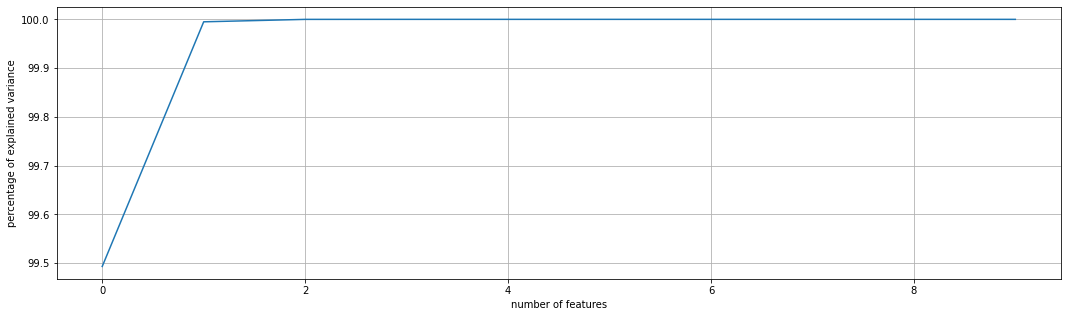

In [ ]:
# Remove the correlated features using PCA
features_data_frame_corr = train_features[correlated_columns]

# plot the percentage of explained variance in order to determine the number of Principle Components to use 
plt.figure(figsize=(18,5))
pca = PCA()
pca.fit(features_data_frame_corr)   
explained_variance = np.cumsum((pca.explained_variance_ratio_ )*100) 

plt.plot(np.arange(len(explained_variance )),explained_variance)
plt.xlabel('number of features')
plt.ylabel('percentage of explained variance')
plt.grid()

- As we can see two components explain 100% of the variance. So I'm going to replace the correlated features by two principal components which are uncorrelated.


In [ ]:
n_components = 2 
pca = PCA(n_components = n_components)
features_data_frame_PCA = pca.fit_transform(features_data_frame_corr)



In [ ]:
data = train_features.drop(columns = correlated_columns)
features_data_frame_PCA = (data.merge(pd.DataFrame(features_data_frame_PCA ,index=data.index , columns=['PC1','PC2']),on=data.index))

In [ ]:
# displaying the final features data frame that it will be used to train the machine learning algorithms 
features_data_frame_PCA 

,key_0,Unnamed: 0,ID,solidity,extent,ratio,R_gradient_average,R_gradient_var,hist_R_mean,hist_G_mean,...,equi_diameter,homogeneity,correlation,contrast,energy,SEX,AGE,POSITION,PC1,PC2
0,0,0,ISIC_0059970,0.995514,0.778842,0.012317,35.848712,1036.135280,0.031087,0.035832,...,343.058815,0.742518,0.999255,9.038131,0.561953,female,45.0,head/neck,-264.508607,-104.998014
1,1,1,ISIC_0056275,0.996660,0.778410,0.009997,40.434345,1570.289508,0.027996,0.038553,...,422.604738,0.706882,0.999667,4.395062,0.369685,female,50.0,head/neck,22.233221,16.232926
2,2,2,ISIC_0065833,0.522580,0.392428,0.042186,33.064928,4088.028440,0.026761,0.029368,...,345.643371,0.522119,0.915941,78.152439,0.080701,male,75.0,anterior torso,5416.502842,13.441860
3,3,3,ISIC_0033796,0.937118,0.699420,0.029917,17.670207,178.358982,0.040043,0.040210,...,163.857984,0.374718,0.997278,11.182199,0.041783,male,55.0,posterior torso,-225.861789,131.326320
4,4,4,ISIC_0059047,0.996353,0.779833,0.008420,20.585308,83.700913,0.027224,0.030329,...,502.709066,0.585824,0.999436,5.808331,0.169283,female,50.0,upper extremity,-744.061799,-33.323146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,7655,7655,ISIC_0061922,0.819058,0.596011,0.019189,9.495671,38.989541,0.026785,0.032834,...,442.519610,0.596370,0.998197,2.426334,0.051884,male,70.0,lower extremity,-720.135504,2.922973
6787,7656,7656,ISIC_0026813,0.914521,0.711746,0.032698,18.507751,145.280035,0.035174,0.035424,...,157.000895,0.372741,0.993108,9.528339,0.047281,female,40.0,upper extremity,-573.330630,-39.425208
6788,7657,7657,ISIC_0027580,0.711229,0.681475,0.038470,10.759774,336.646619,0.024349,0.030113,...,233.245827,0.388333,0.964924,28.958922,0.040053,male,75.0,upper extremity,-265.405506,-7.987361
6789,7658,7658,ISIC_0012770,0.945242,0.769365,0.070768,7.340638,22.099475,0.035984,0.036444,...,69.140277,0.666520,0.946137,17.172716,0.149483,female,75.0,upper extremity,-787.664912,-20.824661


In [ ]:
# extracting the train classes
ID_column = features_data_frame_PCA['ID']
train_class = []
for id in ID_column:
  train_class.append(metadataTrain_df[metadataTrain_df['ID']==id]['CLASS'].iloc[0])



In [ ]:
# test features 
test_features = pd.read_csv(Working_directory + 'extracted_features_test_final.csv')
test_features.dropna(inplace=True) 

In [ ]:
features_df_test_corr = test_features[correlated_columns]

In [ ]:
n_components = 2 
pca = PCA(n_components = n_components)
features_data_frame_test_PCA = pca.fit_transform(features_df_test_corr)


In [ ]:
data = test_features.drop(columns = correlated_columns)
features_data_frame_test_PCA = (data.merge(pd.DataFrame(features_data_frame_test_PCA ,index=data.index , columns=['PC1','PC2']),on=data.index))

In [ ]:
X_train = features_data_frame_PCA

In [ ]:
X_train

,key_0,Unnamed: 0,ID,solidity,extent,ratio,R_gradient_average,R_gradient_var,hist_R_mean,hist_G_mean,...,equi_diameter,homogeneity,correlation,contrast,energy,SEX,AGE,POSITION,PC1,PC2
0,0,0,ISIC_0059970,0.995514,0.778842,0.012317,35.848712,1036.135280,0.031087,0.035832,...,343.058815,0.742518,0.999255,9.038131,0.561953,female,45.0,head/neck,-264.508607,-104.998014
1,1,1,ISIC_0056275,0.996660,0.778410,0.009997,40.434345,1570.289508,0.027996,0.038553,...,422.604738,0.706882,0.999667,4.395062,0.369685,female,50.0,head/neck,22.233221,16.232926
2,2,2,ISIC_0065833,0.522580,0.392428,0.042186,33.064928,4088.028440,0.026761,0.029368,...,345.643371,0.522119,0.915941,78.152439,0.080701,male,75.0,anterior torso,5416.502842,13.441860
3,3,3,ISIC_0033796,0.937118,0.699420,0.029917,17.670207,178.358982,0.040043,0.040210,...,163.857984,0.374718,0.997278,11.182199,0.041783,male,55.0,posterior torso,-225.861789,131.326320
4,4,4,ISIC_0059047,0.996353,0.779833,0.008420,20.585308,83.700913,0.027224,0.030329,...,502.709066,0.585824,0.999436,5.808331,0.169283,female,50.0,upper extremity,-744.061799,-33.323146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,7655,7655,ISIC_0061922,0.819058,0.596011,0.019189,9.495671,38.989541,0.026785,0.032834,...,442.519610,0.596370,0.998197,2.426334,0.051884,male,70.0,lower extremity,-720.135504,2.922973
6787,7656,7656,ISIC_0026813,0.914521,0.711746,0.032698,18.507751,145.280035,0.035174,0.035424,...,157.000895,0.372741,0.993108,9.528339,0.047281,female,40.0,upper extremity,-573.330630,-39.425208
6788,7657,7657,ISIC_0027580,0.711229,0.681475,0.038470,10.759774,336.646619,0.024349,0.030113,...,233.245827,0.388333,0.964924,28.958922,0.040053,male,75.0,upper extremity,-265.405506,-7.987361
6789,7658,7658,ISIC_0012770,0.945242,0.769365,0.070768,7.340638,22.099475,0.035984,0.036444,...,69.140277,0.666520,0.946137,17.172716,0.149483,female,75.0,upper extremity,-787.664912,-20.824661


In [ ]:
X_test = features_data_frame_test_PCA 

In [ ]:
y_test = train_class[:6343]

In [ ]:
# Split training dataset into train and validation datasets
#X_train, X_test, y_train, y_test = train_test_split(features_data_frame_PCA, train_class, test_size=0.25, random_state=42, shuffle=True, stratify=train_class)

In [ ]:
column_id_train = X_train['ID']
column_id_test = X_test['ID']

In [ ]:
X_train.drop(columns = ['ID','SEX','AGE','POSITION'],inplace=True)

In [ ]:
X_train


,key_0,Unnamed: 0,solidity,extent,ratio,R_gradient_average,R_gradient_var,hist_R_mean,hist_G_mean,hist_B_mean,hist_H_mean,equi_diameter,homogeneity,correlation,contrast,energy,PC1,PC2
0,0,0,0.995514,0.778842,0.012317,35.848712,1036.135280,0.031087,0.035832,0.039692,0.010824,343.058815,0.742518,0.999255,9.038131,0.561953,-264.508607,-104.998014
1,1,1,0.996660,0.778410,0.009997,40.434345,1570.289508,0.027996,0.038553,0.036898,0.012986,422.604738,0.706882,0.999667,4.395062,0.369685,22.233221,16.232926
2,2,2,0.522580,0.392428,0.042186,33.064928,4088.028440,0.026761,0.029368,0.029634,0.018533,345.643371,0.522119,0.915941,78.152439,0.080701,5416.502842,13.441860
3,3,3,0.937118,0.699420,0.029917,17.670207,178.358982,0.040043,0.040210,0.032922,0.013019,163.857984,0.374718,0.997278,11.182199,0.041783,-225.861789,131.326320
4,4,4,0.996353,0.779833,0.008420,20.585308,83.700913,0.027224,0.030329,0.037658,0.011336,502.709066,0.585824,0.999436,5.808331,0.169283,-744.061799,-33.323146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,7655,7655,0.819058,0.596011,0.019189,9.495671,38.989541,0.026785,0.032834,0.036178,0.016285,442.519610,0.596370,0.998197,2.426334,0.051884,-720.135504,2.922973
6787,7656,7656,0.914521,0.711746,0.032698,18.507751,145.280035,0.035174,0.035424,0.032050,0.008993,157.000895,0.372741,0.993108,9.528339,0.047281,-573.330630,-39.425208
6788,7657,7657,0.711229,0.681475,0.038470,10.759774,336.646619,0.024349,0.030113,0.030381,0.013559,233.245827,0.388333,0.964924,28.958922,0.040053,-265.405506,-7.987361
6789,7658,7658,0.945242,0.769365,0.070768,7.340638,22.099475,0.035984,0.036444,0.033215,0.013463,69.140277,0.666520,0.946137,17.172716,0.149483,-787.664912,-20.824661


In [ ]:
X_test.drop(columns=['ID'],inplace=True)

In [ ]:
X_test

,key_0,Unnamed: 0,solidity,extent,ratio,R_gradient_average,R_gradient_var,hist_R_mean,hist_G_mean,hist_B_mean,hist_H_mean,equi_diameter,homogeneity,correlation,contrast,energy,PC1,PC2
0,0,0,0.909246,0.750596,0.032667,22.192218,511.307898,0.036715,0.037603,0.033742,0.010273,149.772942,0.577851,0.998899,4.615743,0.094229,20.937774,1.481468
1,1,1,0.926611,0.725320,0.049017,36.860898,2014.911446,0.034254,0.028808,0.025685,0.010272,104.708480,0.275891,0.893290,134.075732,0.044347,2022.386136,101.673550
2,2,2,0.763305,0.496148,0.055778,38.608140,1478.254427,0.032135,0.039007,0.044350,0.011596,132.162539,0.353164,0.989418,26.086620,0.040800,1920.533683,-252.935823
3,3,3,0.820901,0.613797,0.016322,7.762686,72.091447,0.024019,0.028768,0.028560,0.015943,366.248134,0.680287,0.997684,1.910645,0.073734,-585.205015,32.428747
4,4,4,0.970382,0.787113,0.011022,20.772528,1155.907459,0.036180,0.034868,0.029563,0.014462,418.824799,0.480162,0.996421,24.880288,0.060993,1072.389229,-42.626612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,6338,6338,0.985894,0.703893,0.039921,3.612779,18.701730,0.023223,0.031063,0.033807,0.006761,112.014013,0.509561,0.978549,7.096235,0.078643,-749.072068,29.907980
6339,6339,6339,0.975013,0.787241,0.013109,13.721377,240.779177,0.033985,0.040552,0.040287,0.015894,337.818142,0.533752,0.996777,8.388725,0.077778,-363.962946,6.626385
6340,6340,6340,0.999562,0.963237,0.009222,9.990805,150.111264,0.029358,0.037896,0.040045,0.012094,489.447390,0.477916,0.994772,6.794652,0.043148,-525.077840,-6.922065
6341,6341,6341,0.952047,0.717127,0.066595,6.265596,20.396017,0.026634,0.035305,0.032210,0.011125,74.996905,0.628307,0.968821,8.655993,0.123174,-745.595859,24.805330


In [ ]:
# scaling data :
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# IV- Classification : 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

- **Decision Trees :**

As we have seen Decision Trees are robust to outliers and they are good classifiers for non balanced datasets. So I will apply decision trees and I will use cross-validation to tune its hyperparameters.

In [ ]:
class_names = ['Melanoma','Melanocytic nevus','Basal cell carcinoma','Actinic keratosis','Benign keratosis','Dermatofibroma','Vascular lesion','Squamous cell carcinoma']
# Define classifier 
Tree = DecisionTreeClassifier(random_state=0)

# cross validation
p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10,11], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11], 
                'max_leaf_nodes': [10,11,12,13,14,15,16]} 


grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, scoring='f1', cv=5)

# Train the classifier
grid_tree.fit(X_train, train_class)

#best parameters
best_params = grid_tree.best_params_
print('Best parameters : ',best_params)

# Compute best model
best_model_tree = DecisionTreeClassifier(min_samples_split = best_params['min_samples_split'], 
min_samples_leaf = best_params['min_samples_leaf'], max_leaf_nodes = best_params['max_leaf_nodes'])

# Train best model
best_model_tree.fit(X_train,train_class)

# prediction
y_pred_test = best_model_tree.predict(X_test)
# Print train and test scores  print("Decision Tree train accuracy :", best_model_tree.score(X_train,y_train))
print("Decision Tree test accuracy :", best_model_tree.score(X_test,y_test))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_test)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1131, in f1_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1270, in fbeta_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py"

Best parameters :  {'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree test accuracy : 0.3544064322875611


- **Random Forest :**<br>


Since I didn't get a good performance with the decision Trees and I got many warning I will try to improve it by an algorithm that minimize the variance of the decision trees which is Random Forest.In fact,Random forest levareges the power of many decision trees which leads to minimizing the variance and to producing better predictions.texte en gras

In [ ]:
from sklearn.ensemble import RandomForestClassifier
class_names = ['Melanoma','Melanocytic nevus','Basal cell carcinoma','Actinic keratosis','Benign keratosis','Dermatofibroma','Vascular lesion','Squamous cell carcinoma']
# Define classifier 
RF = RandomForestClassifier(random_state=0)

# Define parameters for cross validation
p_grid_RF = {'n_estimators': [10, 15, 20, 25, 30], 'min_samples_leaf': [
      2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2'],'max_leaf_nodes': [10,11,12,13,14,15,16,17,18,19]}

# Compute cross validation
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF,
                        scoring='accuracy', cv=5)

# Train the classifier
grid_RF.fit(X_train, train_class)

# best parameters
best_params = grid_RF.best_params_
print("Best params: {}".format(best_params))

# Compute best model
best_model_RF = RandomForestClassifier(n_estimators=best_params['n_estimators'], min_samples_leaf=best_params['min_samples_leaf'],
                                        max_features=best_params['max_features'], max_leaf_nodes = best_params['max_leaf_nodes'], random_state=0)

# Fit best model
best_model_RF.fit(X_train,train_class)

# prediction
y_pred_test = best_model_RF.predict(X_test)

# Print train and test scores
print("Random Forest train accuracy :", best_model_RF.score(X_train,train_class))
print("Random Forest test accuracy :", best_model_RF.score(X_test,y_test))

Best params: {'max_features': 'sqrt', 'max_leaf_nodes': 19, 'min_samples_leaf': 5, 'n_estimators': 30}
Random Forest train accuracy : 0.5645707554115741
Random Forest test accuracy : 0.381049976351884


In [ ]:
from sklearn.ensemble import RandomForestClassifier
class_names = ['Melanoma','Melanocytic nevus','Basal cell carcinoma','Actinic keratosis','Benign keratosis','Dermatofibroma','Vascular lesion','Squamous cell carcinoma']
# Define classifier 
RF = RandomForestClassifier(random_state=0)

# Define parameters for cross validation
p_grid_RF = {'n_estimators': [10, 15, 20, 25, 30], 'min_samples_leaf': [
      2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2'],'max_leaf_nodes': [10,11,12,13,14,15,16,17,18,19]}

# Compute cross validation
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF,
                        scoring='accuracy', cv=5)

# Train the classifier
grid_RF.fit(X_train, train_class)

# best parameters
best_params = grid_RF.best_params_
print("Best params: {}".format(best_params))

# Compute best model
best_model_RF = RandomForestClassifier(n_estimators=best_params['n_estimators'], min_samples_leaf=best_params['min_samples_leaf'],
                                        max_features=best_params['max_features'], max_leaf_nodes = best_params['max_leaf_nodes'], random_state=0)

# Fit best model
best_model_RF.fit(X_train,train_class)

# prediction
y_pred_test = best_model_RF.predict(X_test)

# Print train and test scores
print("Decision Tree train accuracy :", best_model_RF.score(X_train,train_class))
print("Decision Tree test accuracy :", best_model_RF.score(X_test,y_test))



Best params: {'max_features': 'sqrt', 'max_leaf_nodes': 19, 'min_samples_leaf': 3, 'n_estimators': 30}
Decision Tree train accuracy : 0.5632454719481667
Decision Tree test accuracy : 0.38073466813810497


- **I didn't get a very high accuracy because there are images which were not well segmented because of the color of the lesion which can be close to the normal skin. So the segmentation is a very important step that influences the feature extraction step and thus the performance of the model.**

# VI- Submission File :

In [ ]:
df_submission = pd.DataFrame()
df_submission['ID'] = column_id_test
column_class = []
i = 0
for id in column_id_test :
  value = y_pred_test[i]
  column_class.append(value) 
  i+1 
df_submission['CLASS'] = column_class


In [ ]:
df_submission.reset_index(drop = True, inplace=True)

In [ ]:
df_submission

,ID,CLASS
0,ISIC_0072313,2
1,ISIC_0012549,2
2,ISIC_0026847,2
3,ISIC_0067423,2
4,ISIC_0057138,2
...,...,...
6338,ISIC_0001247,2
6339,ISIC_0009904,2
6340,ISIC_0010056,2
6341,ISIC_0012306,2


In [ ]:
df_submission.to_csv('/content/drive/MyDrive/ChallengeIMA/Data/submission_file_final3.csv', index = False)